In [1]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, TrainingArguments, Trainer, set_seed
from transformers import DataCollatorForTokenClassification
import pandas as pd
import thesis_utils
from datasets import Dataset
from datasets import Sequence, ClassLabel, Features, Value
from evaluate import load
import random
import numpy as np
import csv
from collections import Counter
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
from sklearn.metrics import precision_recall_fscore_support

/home/elisabetta/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")
comet_ml is installed but `COMET_API_KEY` is not set.


In [2]:
import warnings
warnings.filterwarnings("ignore", message=".*seems not to be NE tag.*")

### Loading the model

In [4]:
model_checkpoint = "xlm-roberta-base"
tokenizer = AutoTokenizer.from_pretrained(model_checkpoint)

/home/elisabetta/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


In [5]:
task = "GED-en"
batch_size = 8

### Statistics

In [7]:
multiged_fce_train =  thesis_utils.read_tsv_file_and_find_sentences('./MULTI-GED2023 DATA/en_fce_train.tsv')
multiged_fce_dev =  thesis_utils.read_tsv_file_and_find_sentences('./MULTI-GED2023 DATA/en_fce_dev.tsv')
#multiged_fce_test=  thesis_utils.read_tsv_file_and_find_sentences('./MULTI-GED2023 DATA/en_fce_test_unlabelled.tsv')
multiged_realec_dev=  thesis_utils.read_tsv_file_and_find_sentences('./MULTI-GED2023 DATA/en_realec_dev.tsv')
#multiged_realec_test=  thesis_utils.read_tsv_file_and_find_sentences('./MULTI-GED2023 DATA/en_realec_test_unlabelled.tsv')

In [8]:
print(f'Number of training sentences: {len(multiged_fce_train)}\n')
print(f'Number of dev (FCE) sentences: {len(multiged_fce_dev)}\n')
print(f'Number of dev (REALES) sentences: {len(multiged_realec_dev)}\n')
#print(f'Number of test (FCE) sentences: {len(multiged_fce_test)}\n')
#print(f'Number of test (REALEC) sentences: {len(multiged_realec_test)}\n')

print(f'Number of training tokens: {thesis_utils.token_counter(multiged_fce_train)}\n')
print(f'Number of dev tokens (FCE): {thesis_utils.token_counter(multiged_fce_dev)}\n')
print(f'Number of dev tokens (REALEC): {thesis_utils.token_counter(multiged_realec_dev)}\n')
#print(f'Number of test tokens(FCE): {thesis_utils.token_counter(multiged_fce_test)}\n')
#print(f'Number of test tokens (REALEC): {thesis_utils.token_counter(multiged_realec_test)}')

Number of training sentences: 28357

Number of dev (FCE) sentences: 2191

Number of dev (REALES) sentences: 4067

Number of training tokens: 454730

Number of dev tokens (FCE): 34748

Number of dev tokens (REALEC): 88008



### Preprocessing

In [10]:
multiged_labels = ['c','i']
training_sents_idx, training_sents_tokens, training_sents_gold = thesis_utils.get_list_ids_tokens_gold(multiged_fce_train)
dev_sents_idx_fce, dev_sents_tokens_fce, dev_labels_fce= thesis_utils.get_list_ids_tokens_gold(multiged_fce_dev)
dev_sents_idx_realec, dev_sents_tokens_realec, dev_labels_realec = thesis_utils.get_list_ids_tokens_gold(multiged_realec_dev)
# test_sents_idx_fce, test_sents_tokens_fce, test_labels_fce = thesis_utils.get_list_ids_tokens_gold(multiged_fce_test)
# test_sents_idx_realec, test_sents_tokens_realec, test_labels_realec = thesis_utils.get_list_ids_tokens_gold(multiged_realec_test)

In [11]:
#print(test_sents_tokens_realec[:2])

In [12]:
training_list_dict = thesis_utils.create_list_dict(training_sents_idx, training_sents_tokens, training_sents_gold)
dev_list_dict_fce = thesis_utils.create_list_dict(dev_sents_idx_fce, dev_sents_tokens_fce, dev_labels_fce)
dev_list_dict_realec = thesis_utils.create_list_dict(dev_sents_idx_realec, dev_sents_tokens_realec, dev_labels_realec)
# test_list_dict_fce = thesis_utils.create_list_dict(test_sents_idx_fce, test_sents_tokens_fce, test_labels_fce)
# test_list_dict_realec = thesis_utils.create_list_dict(test_sents_idx_realec, test_sents_tokens_realec, test_labels_realec)

In [13]:
training_df = pd.DataFrame(training_list_dict)
training_dataset = Dataset.from_pandas(training_df)

fce_dev_df = pd.DataFrame(dev_list_dict_fce)
fce_dev_dataset = Dataset.from_pandas(fce_dev_df)

realec_dev_df = pd.DataFrame(dev_list_dict_realec)
realec_dev_dataset = Dataset.from_pandas(realec_dev_df)

# fce_test_df = pd.DataFrame(test_list_dict_fce)
# fce_test_dataset = Dataset.from_pandas(fce_test_df)

# realec_test_df = pd.DataFrame(test_list_dict_realec)
# realec_test_dataset = Dataset.from_pandas(realec_test_df)

In [14]:
new_features = Features({
    "id_token": Sequence(Value("int64")),
    "token": Sequence(Value("string")),
    "labels": Sequence(ClassLabel(names=multiged_labels)),
})

training_dataset = training_dataset.cast(new_features)
fce_dev_dataset = fce_dev_dataset.cast(new_features)
realec_dev_dataset=realec_dev_dataset.cast(new_features)
#fce_test_dataset = fce_test_dataset.cast(new_features)
#realec_test_dataset=realec_test_dataset.cast(new_features)

Casting the dataset:   0%|          | 0/28357 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/2191 [00:00<?, ? examples/s]

Casting the dataset:   0%|          | 0/4067 [00:00<?, ? examples/s]

In [15]:
example_sentence = training_dataset['token'][3]
example_sentence_id = training_dataset['id_token'][3]
tokenized_input = tokenizer(example_sentence, truncation=True, is_split_into_words=True)
tokens = tokenizer.convert_ids_to_tokens(tokenized_input["input_ids"])

In [16]:
print(f'Original tokens: \n{example_sentence}')
print()
print(f'Tokens and subword tokens obtained through the AutoTokenizer of BERT (distilbert-base-uncased): \n{tokens}')
print()
print(f'Number of the original token IDs: {len(example_sentence_id)} >>>  \n{example_sentence_id}')
print()
print(f'Number of the tokens and subword token IDs: {len(tokenized_input.word_ids())} >>> \n{tokenized_input.word_ids()}')
print()
print(f'Representation of the input IDs: \n{tokenized_input['input_ids']}') 
print()
print(f'Representation of the attention mask: \n{tokenized_input['attention_mask']}')

Original tokens: 
['I', 'convinced', 'them', 'to', 'go', 'there', 'with', 'me', 'because', 'I', 'had', 'heard', 'good', 'references', 'about', 'your', 'Company', 'and', ',', 'above', 'all', ',', 'about', 'the', 'main', 'star', ',', 'Danny', 'Brook', '.']

Tokens and subword tokens obtained through the AutoTokenizer of BERT (distilbert-base-uncased): 
['<s>', '▁I', '▁convince', 'd', '▁them', '▁to', '▁go', '▁there', '▁with', '▁me', '▁because', '▁I', '▁had', '▁heard', '▁good', '▁reference', 's', '▁about', '▁your', '▁Company', '▁and', '▁', ',', '▁above', '▁all', '▁', ',', '▁about', '▁the', '▁main', '▁star', '▁', ',', '▁Danny', '▁Brook', '▁', '.', '</s>']

Number of the original token IDs: 30 >>>  
[1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

Number of the tokens and subword token IDs: 38 >>> 
[None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18, 18, 19, 20, 21, 21, 22, 23, 24, 25, 26, 26, 27, 28, 

In [17]:
label_all_tokens = True

def tokenize_and_align_labels(dataset):
    tokenized_inputs = tokenizer(dataset["token"], truncation=True, is_split_into_words=True)
    labels = []
    tokenized_ids = []
    for i, label in enumerate(dataset["labels"]):
        word_ids = tokenized_inputs.word_ids(batch_index=i)
        previous_word_idx = None
        label_ids = []
        for word_idx in word_ids:
            if word_idx is None:
                label_ids.append(-100)
            elif word_idx != previous_word_idx:
                label_ids.append(label[word_idx])
            else:
                label_ids.append(label[word_idx] if label_all_tokens else -100)
            previous_word_idx = word_idx

        labels.append(label_ids)
        tokenized_ids.append(word_ids)
    tokenized_inputs["t_word_id"] = tokenized_ids
    tokenized_inputs["labels"] = labels
    return tokenized_inputs

In [18]:
tokenized_training_dataset = training_dataset.map(tokenize_and_align_labels, batched=True)
tokenized_fce_dev_dataset = fce_dev_dataset.map(tokenize_and_align_labels, batched = True)
tokenized_realec_dev_dataset = realec_dev_dataset.map(tokenize_and_align_labels, batched =True)

Map:   0%|          | 0/28357 [00:00<?, ? examples/s]

Map:   0%|          | 0/2191 [00:00<?, ? examples/s]

Map:   0%|          | 0/4067 [00:00<?, ? examples/s]

In [19]:
print(tokenized_training_dataset[3])

{'id_token': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30], 'token': ['I', 'convinced', 'them', 'to', 'go', 'there', 'with', 'me', 'because', 'I', 'had', 'heard', 'good', 'references', 'about', 'your', 'Company', 'and', ',', 'above', 'all', ',', 'about', 'the', 'main', 'star', ',', 'Danny', 'Brook', '.'], 'labels': [-100, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, -100], 'input_ids': [0, 87, 122991, 71, 2856, 47, 738, 2685, 678, 163, 6637, 87, 1902, 49782, 4127, 91067, 7, 1672, 935, 33734, 136, 6, 4, 36917, 756, 6, 4, 1672, 70, 5201, 6057, 6, 4, 139020, 134331, 6, 5, 2], 'attention_mask': [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1], 't_word_id': [None, 0, 1, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 13, 14, 15, 16, 17, 18, 18, 19, 20, 21, 21, 22, 23, 24, 25, 26, 26, 27, 28, 29, 29, None

### Training

In [21]:
SEED = 1234
random.seed(SEED)   
np.random.seed(SEED)  
set_seed(SEED)  

model_name = model_checkpoint.split("/")[-1]
args = TrainingArguments(
    f"{model_name}-finetuned-{task}",
    evaluation_strategy="epoch",  # <- fixed here
    learning_rate=2e-5,
    per_device_train_batch_size=batch_size,
    per_device_eval_batch_size=batch_size,
    num_train_epochs=3,
    weight_decay=0.01,
    seed=SEED,
    report_to=None,
)

/home/elisabetta/anaconda3/lib/python3.12/site-packages/torch/cuda/__init__.py:734: UserWarning: Can't initialize NVML
  warnings.warn("Can't initialize NVML")


In [22]:
data_collator = DataCollatorForTokenClassification(tokenizer)
model = AutoModelForTokenClassification.from_pretrained(model_checkpoint, num_labels=len(multiged_labels))

/home/elisabetta/anaconda3/lib/python3.12/site-packages/huggingface_hub/file_download.py:797: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [23]:
metric = load("seqeval")

In [24]:
def compute_metrics(p):
    predictions, labels = p
    predictions = np.argmax(predictions, axis=2)

    true_predictions = [
        [multiged_labels[p] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]
    true_labels = [
        [multiged_labels[l] for (p, l) in zip(prediction, label) if l != -100]
        for prediction, label in zip(predictions, labels)
    ]

    results = metric.compute(predictions=true_predictions, references=true_labels)
    return {
        "precision": results["overall_precision"],
        "recall": results["overall_recall"],
        "f1": results["overall_f1"],
        "accuracy": results["overall_accuracy"],
    }

In [25]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_training_dataset,
    eval_dataset=tokenized_fce_dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [26]:
trainer.train()

Epoch,Training Loss,Validation Loss,Precision,Recall,F1,Accuracy
1,0.204900,0.202459,0.000000,0.000000,0.000000,0.924972
2,0.170000,0.211030,0.000000,0.000000,0.000000,0.927199
3,0.143300,0.220431,0.000000,0.000000,0.000000,0.928910


/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/s

TrainOutput(global_step=10635, training_loss=0.18048534886513062, metrics={'train_runtime': 19283.2583, 'train_samples_per_second': 4.412, 'train_steps_per_second': 0.552, 'total_flos': 1834647715315620.0, 'train_loss': 0.18048534886513062, 'epoch': 3.0})

### Saving the fine-tuned model

In [28]:
trainer.save_model('fine_tuned_ged_xlmroberta_en')
trainer.tokenizer.save_pretrained('fine_tuned_ged_xlmroberta_en')

('fine_tuned_ged_xlmroberta_en/tokenizer_config.json',
 'fine_tuned_ged_xlmroberta_en/special_tokens_map.json',
 'fine_tuned_ged_xlmroberta_en/sentencepiece.bpe.model',
 'fine_tuned_ged_xlmroberta_en/added_tokens.json',
 'fine_tuned_ged_xlmroberta_en/tokenizer.json')

### Loading the fine-tuned model

In [30]:
from transformers import AutoTokenizer, AutoModelForTokenClassification, Trainer
model_name = 'fine_tuned_ged_xlmroberta_en'
model = AutoModelForTokenClassification.from_pretrained('fine_tuned_ged_xlmroberta_en')
tokenizer = AutoTokenizer.from_pretrained('fine_tuned_ged_xlmroberta_en', use_fast=True)

In [31]:
trainer.evaluate()

/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'eval_loss': 0.22043104469776154,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.9289096193512094,
 'eval_runtime': 79.7546,
 'eval_samples_per_second': 27.472,
 'eval_steps_per_second': 3.436,
 'epoch': 3.0}

In [32]:
predictions, labels, _ = trainer.predict(tokenized_fce_dev_dataset)
predictions = np.argmax(predictions, axis=2)

### Postprocessing (FCE)

In [34]:
output_file_path = "predictions_xlmroberta_fce.tsv"
dev_fce_tokens, dev_fce_labels, dev_fce_predictions = thesis_utils.map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_fce_dev_dataset, output_file_path,multiged_labels,tokenizer)

Results saved to predictions_xlmroberta_fce.tsv


### Results and Confusion Metrix (FCE)

              precision    recall    f0.5-score    support
c               0.9401    0.984083    0.94855        31288
i               0.7504    0.432659    0.65428        3460

micro avg       0.9292    0.929176    0.92918        34748
macro avg       0.8452    0.708371    0.80142        34748


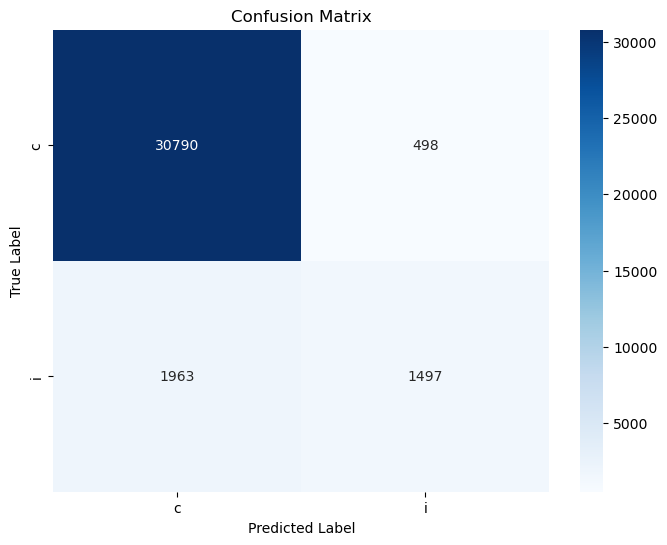

In [36]:
thesis_utils.evaluate_predictions(dev_fce_predictions, dev_fce_labels)

In [37]:
trainer = Trainer(
    model,
    args,
    train_dataset=tokenized_training_dataset,
    eval_dataset=tokenized_realec_dev_dataset,
    data_collator=data_collator,
    tokenizer=tokenizer,
    compute_metrics=compute_metrics
)

In [38]:
trainer.evaluate()

/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/seqeval/metrics/v1.py:57: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 due to no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/lib/function_base.py:520: RuntimeWarning: Mean of empty slice.
  avg = a.mean(axis, **keepdims_kw)
/home/elisabetta/anaconda3/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


{'eval_loss': 0.32523980736732483,
 'eval_precision': 0.0,
 'eval_recall': 0.0,
 'eval_f1': 0.0,
 'eval_accuracy': 0.9045413193219584,
 'eval_runtime': 171.5079,
 'eval_samples_per_second': 23.713,
 'eval_steps_per_second': 2.968}

In [39]:
predictions, labels, _ = trainer.predict(tokenized_realec_dev_dataset)
predictions = np.argmax(predictions, axis=2)

### Postprocessing (REALEC)

In [44]:
output_file_path = "predictions_xlmroberta_realec.tsv"
dev_realec_tokens, dev_realec_labels, dev_realec_predictions = thesis_utils.map_predictions_to_words_and_save_to_file(predictions, labels, tokenized_realec_dev_dataset, output_file_path,multiged_labels,tokenizer)

Results saved to predictions_xlmroberta_realec.tsv


### Results and Confusion Metrix (REALEC)

              precision    recall    f0.5-score    support
c               0.9367    0.960741    0.94145        79905
i               0.4820    0.360237    0.45148        8103

micro avg       0.9055    0.905452    0.90545        88008
macro avg       0.7094    0.660489    0.69646        88008


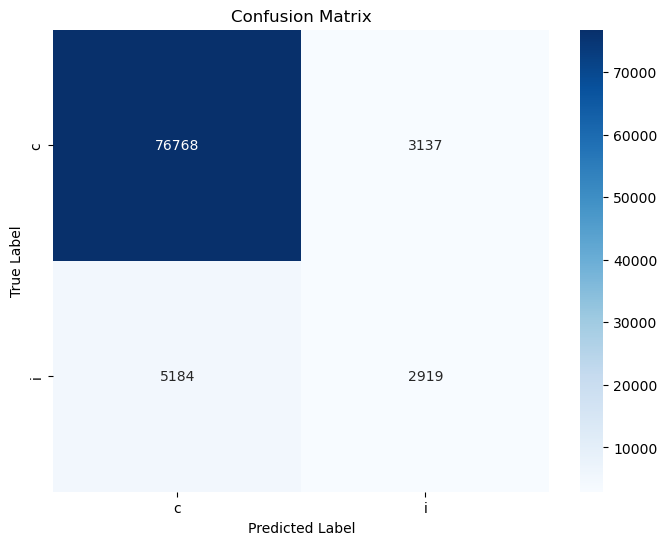

In [46]:
thesis_utils.evaluate_predictions(dev_realec_predictions, dev_realec_labels)